THIS NOTEBOOK IS BASED ON THE PREVIOUS ONE, BUT SET STANDARD LIMITS FOR $\theta$ SO I DON'T MESS THE CONVERSION

The goal of this notebook is to develop a simple model to measure the isotropy of a given configuration of points on a sphere. First, I would like to explain the measure that I am trying to test.

Consider a sphere with N points on it. Consider a fixed "opening angle" $\alpha$, pick a direction from the centre $\overrightarrow{u}$ (i.e. a point on the sphere, not necessarily one of the N) and count the number of points n out of the total N that lie inside the spherical cap of opening angle $\alpha$ centered on this direction.

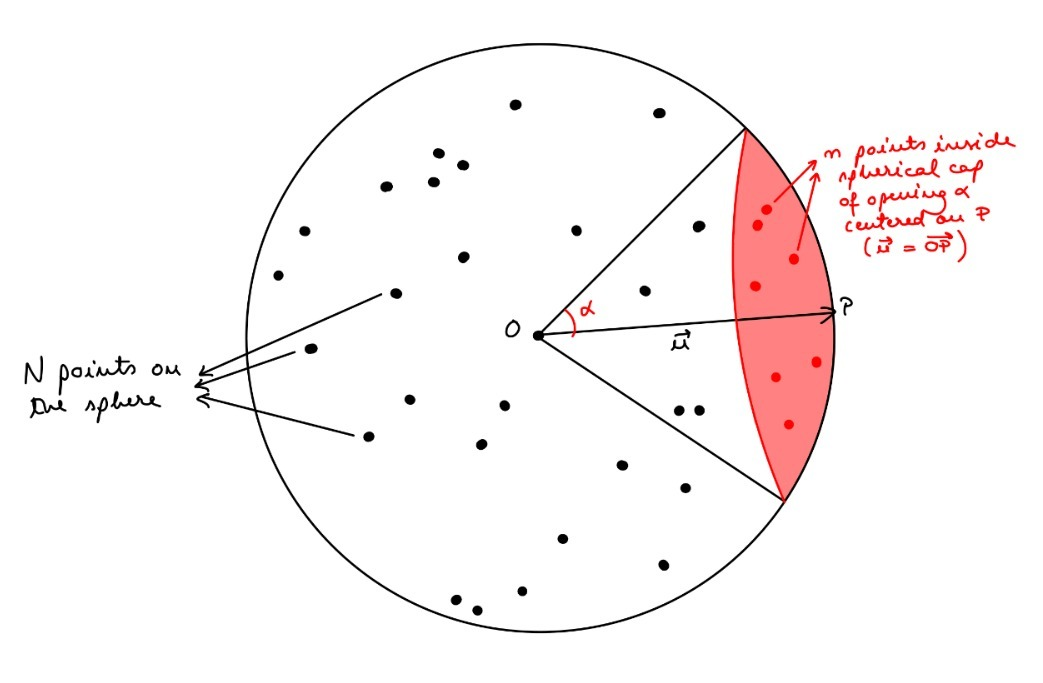



We will look at a large number of directions (these could be random or we could pick an isotropic arrangement of directions from the start, but I'll go with the second option for now) and plot the distribution of number of points in the spherical cap of opening $\alpha$ for each direction. For an isotropic distribution of the N points on the sphere, we expect this to be sharply peaked around $N \cdot \frac{A_{cap}}{A_{sphere}}$. 


As the distribution becomes less isotropic, expect the normalized variance of this distribution to increase. If this holds, define the isotropy measure $I_{\alpha} = \frac{\mathrm{Var}[n]}{\bar{n}}$, whee $\bar{n}$ is the mean of the distribution and $\mathrm{Var}[n]$ is the variance.

The overall plan for using this to define an isotropy criterion is the following:

1) Select a bunch of runs with various good PMT distributions
<br>

2) Simulate some electrons with fixed energy and look at the distribution of reconstructed energies. This should also be sharply peaked for good energy reconstruction, and we expect this to get worse as we have less and less active PMT's and as they are less and less isotropically distributed on the sphere (i.e. if we have big gaps)
<br>

3) Define what a "good" run is based on the width or variance of the distribution of reconstructed energies
<br>

4) Fix a value for $\alpha$
<br>

5) For each run, compute the mean n for the selected set of directions and the variance of the distribution
<br>

6) The set of "sufficiently isotropic" PMT configurations is defined by an upper limit on $\mathrm{Var}[n]$, $\mathrm{Var}[n]_{max}$
<br>

7) The set of "sufficiently dense" PMT configurations is defined by a lower limit on $\bar{n}$, $\bar{n}_{min}$
<br>

8) Find the values $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}$ and $\bar{n}_{min}$ that result in the greatest overlap between the "good" runs as defined by energy reconstruction, and the "good" runs defined by the parameters of the $n$ distribution

We could apply this procedure for different values of $\alpha$ and get different values for $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}(\alpha)$ and $\bar{n}_{min}(\alpha)$. We can set different criteria for different values of $\alpha$, but in order to keep this as computationally cheap as possible, we want to look for the value of $\alpha$ (and the associated $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}(\alpha)$ and $\bar{n}_{min}(\alpha)$) that maximises the overlap between the sets of good runs defined in the two different ways.

**Note**: I think finding the best value for $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}$ is enough for an isotropy criterion, but would be good to also have a density criterion; we might not need a separate coverage criterion if we do this

**Note**: When we pick the set of directions we're looking at, we might wish to avoid directions around the neck -- discuss in RS call

For now, we won't worry about definig good runs based on energy reconstruction, and we'll just look at some arrangements of points and their associated n-distribution. The points are defined by coordinates $\phi$ and $\theta$, with $\phi \in [0, 2\pi)$ and $\theta \in [-\pi/2, \pi/2)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def generate_random_numbers(m, n, count):
    return np.random.uniform(m, n, count)

We will look at sets of $N = 1000$ points.

In [3]:
def generate_points(N):
    phi_array = generate_random_numbers(0, 2*np.pi, N)
    theta_array = generate_random_numbers(0, np.pi, N)
    return phi_array, theta_array

In [4]:
#generate a set of points
points_phi_1, points_theta_1 = generate_points(1000)

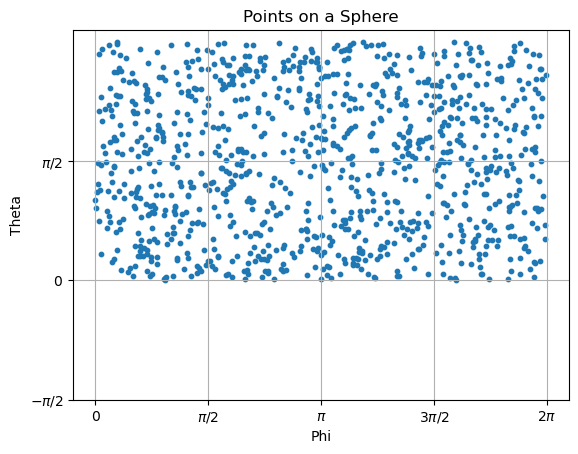

In [5]:
#Plot points on 2D map

plt.scatter(points_phi_1, points_theta_1, s = 10)

# Set x-axis ticks at multiples of pi/2
plt.xticks(np.arange(0, 2*np.pi + np.pi/2, np.pi/2), 
           ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

# Set y-axis ticks at multiples of pi/2
plt.yticks(np.arange(-np.pi/2, np.pi/2 + np.pi/2, np.pi/2), 
           ['$-\pi/2$', '$0$', '$\pi/2$'])

plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('Points on a Sphere')
plt.grid(True)
plt.show()

These have been randomly generated and therefore they are quite isotropic. Will construct the desired distribution and we should see that it's quite isotropic. First, define the grid of directions (centres of caps)

Will start by looking at an opening angle of $\alpha = \pi/4$

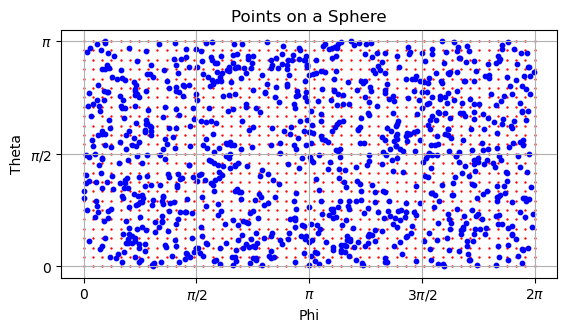

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid sizes
grid_phi_size = 50
grid_theta_size = 25

# Define grid ranges
phi_min, phi_max = 0, 2*np.pi
theta_min, theta_max = 0, np.pi

# Create grid
grid_phi = np.linspace(phi_min, phi_max, grid_phi_size)
grid_theta = np.linspace(theta_min, theta_max, grid_theta_size)

# Create a meshgrid
phi_mesh, theta_mesh = np.meshgrid(grid_phi, grid_theta)

# Flatten the meshgrid and create points
points_phi_grid = phi_mesh.flatten()
points_theta_grid = theta_mesh.flatten()

# Plot the grid points
plt.scatter(points_phi_grid, points_theta_grid, s=0.5, color='red')  # Adjust marker size and color as needed
plt.scatter(points_phi_1, points_theta_1, s=10, color='blue')

# Set x-axis ticks
plt.xticks(np.linspace(phi_min, phi_max, 5), 
           ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])

# Set y-axis ticks
plt.yticks(np.linspace(theta_min, theta_max, 3), 
           ['$0$', '$\pi/2$', '$\pi$'])

plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('Points on a Sphere')

# Set aspect ratio to 'equal'
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)
plt.show()


In [9]:
#make array of the N points in spherical coordinates

points_set_1 = np.ones((1000, 3))

for i in range(len(points_set_1)):
    points_set_1[i][1] = points_phi_1[i]
    points_set_1[i][2] = points_theta_1[i]
    
#make array of the grid_phi_size x grid_theta_size grid points in spherical coordinates

grid_points = np.ones((grid_phi_size*grid_theta_size, 3))

for i in range(len(grid_points)):
    grid_points[i][1] = points_phi_grid[i]
    grid_points[i][2] = points_theta_grid[i]

Here I'll add some explanation of the conversion, probably a screenshot from my ipad

Also, I don't think I needed to add the r coordinate but oh well, I included r = 1 in my conversion

In [10]:
def polars_cartesian_conversion(points_in_polars_array):
    
    #points_in_polars_array should be an array of size (X, 3); each element is (radius, phi, theta)
    #retursn an array of size (X, 3) each element being (x, y, z)
    
    points_in_cartesians_array = np.zeros(points_in_polars_array.shape)
    
    for i in range(len(points_in_polars_array)):
        #x = sin(theta)*cos(phi)
        points_in_cartesians_array[i][0] = np.sin(points_in_polars_array[i][2]) * np.cos(points_in_polars_array[i][1])
        #y = sin(theta)*sin(phi)
        points_in_cartesians_array[i][1] = np.sin(points_in_polars_array[i][2]) * np.sin(points_in_polars_array[i][1])
        #z = cos(theta)
        points_in_cartesians_array[i][2] = np.cos(points_in_polars_array[i][2]) 
        
    return points_in_cartesians_array

In [11]:
points_set_cartesians_1 = polars_cartesian_conversion(points_set_1)
grid_points_cartesians = polars_cartesian_conversion(grid_points)

In [12]:
#function that computes the angle between two vectors

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
    angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return angle_rad

In [13]:
points_in_cap_per_grid_point = np.zeros(len(grid_points_cartesians))

for i in range(len(grid_points_cartesians)): #for each directions
    
    counter = 0
    
    for j in range(len(points_set_cartesians_1)): #for each of the N points
        angle = angle_between_vectors(grid_points_cartesians[i], points_set_cartesians_1[j])
        if angle < np.pi/4:
            counter += 1
            
    points_in_cap_per_grid_point[i] = counter

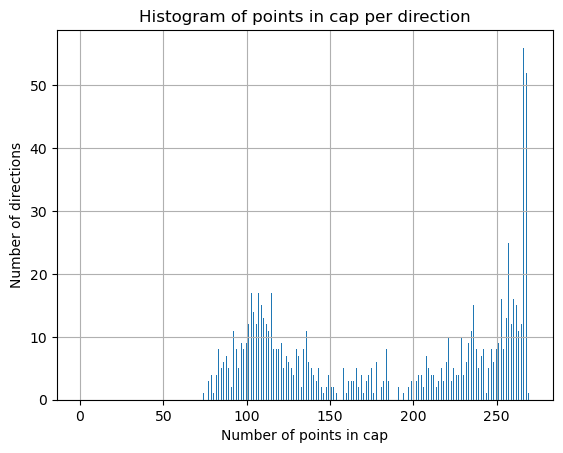

In [14]:
# Compute histogram
hist_values, bin_edges = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges[:-1], hist_values, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)
plt.show()

This is still wrong.... maybe make the cap size larger?


In [15]:
points_in_cap_per_grid_point = np.zeros(len(grid_points_cartesians))

for i in range(len(grid_points_cartesians)): #for each directions
    
    counter = 0
    
    for j in range(len(points_set_cartesians_1)): #for each of the N points
        angle = angle_between_vectors(grid_points_cartesians[i], points_set_cartesians_1[j])
        if angle < np.pi/2:
            counter += 1
            
    points_in_cap_per_grid_point[i] = counter

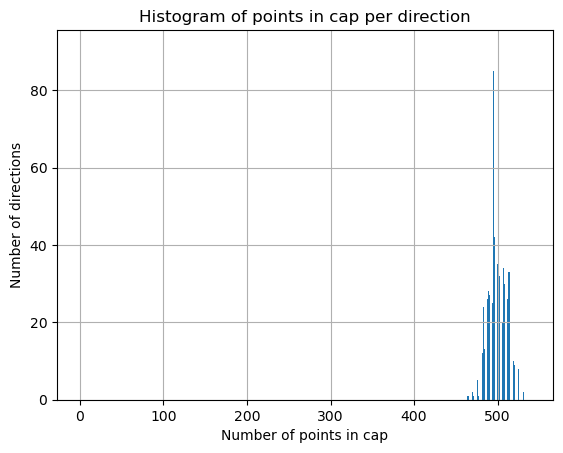

In [16]:
# Compute histogram
hist_values, bin_edges = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges[:-1], hist_values, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)
plt.show()

For the statement to hold, the cap needs to be large enough to contain a significant number of points. The two models align quite well (they are both peaked around 500) if we pick a large cap size, but that's half the sphere! We only tried with 1000 points though, with PMT's we'll most likely have more than 5000 (hopefully); make a third copy of the notebook in which we use way more points